In [1]:
%config InlineBackend.figure_format = 'svg'

In [2]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import genjax
import genjax.prox as prox
from genjax import Normal, TFPUniform
from math import pi as π

sns.set_theme(style="white")

# Pretty printing.
console = genjax.pretty(width=70)

# Reproducibility.
key = jax.random.PRNGKey(314159)

Let's start by defining a model generative program. This example is from [Alex Lew's 2020 LAFI talk on a related language called MetaPPL](https://popl20.sigplan.org/details/lafi-2020/14/MetaPPL-Inference-Algorithms-as-First-Class-Generative-Models).

In [3]:
@genjax.gen
def model():
    x = Normal(0.0, 10.0) @ "x"
    y = Normal(0.0, 10.0) @ "y"
    z = Normal(x**2 + y**2, 1.0) @ "z"
    return z

In [4]:
key, sub_keys = genjax.slash(key, 1000)
_, trs = jax.vmap(model.simulate, in_axes=(0, None))(sub_keys, ())
chm = trs.strip()

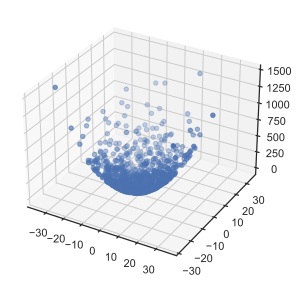

In [5]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(chm["x"], chm["y"], chm["z"])

When we use `prox.chm_dist` (which is shorthand for `prox.ChoiceMapDistribution`) - we're creating a new generative function whose internal proposal `q` can be changed.

In [6]:
prox_model = prox.chm_dist(model, selection=genjax.select(["x", "y"]), custom_q=None)
prox_model

ChoiceMapDistribution
├── p
│   └── BuiltinGenerativeFunction
│       └── source
│           └── <function model>
├── selection
│   └── BuiltinSelection
│       └── trie
│           └── Trie
│               ├── :x
│               │   └── AllSelection
│               └── :y
│                   └── AllSelection
└── custom_q
    └── (const) None

Above, we're keeping the default internal proposal `q` by not providing a `custom_q`. This means that `prox_model` inherits `q` from `model`.

The resulting `prox_model` object is something called a `ChoiceMapDistribution` - it's an approximate distribution over the random choices at the addresses we pass in via `selection`.

We specified `"x"` and `"y"` - which means we are asking for a distribution which is the **marginal** of the full joint of `model`.

$$
P(x, y) = \int P(x, y, z) \ dz
$$

As we know, this is the source of the intractability of Bayesian inference in the first place! So how do we get around this?

In [7]:
key, tr = prox_model.simulate(key, ())
tr

DistributionTrace
├── gen_fn
│   └── ChoiceMapDistribution
│       ├── p
│       │   └── BuiltinGenerativeFunction
│       │       └── source
│       │           └── <function model>
│       ├── selection
│       │   └── BuiltinSelection
│       │       └── trie
│       │           └── Trie
│       │               ├── :x
│       │               │   └── AllSelection
│       │               └── :y
│       │                   └── AllSelection
│       └── custom_q
│           └── (const) None
├── args
│   └── tuple
├── value
│   └── BuiltinChoiceMap
│       └── trie
│           └── Trie
│               ├── :x
│               │   └── ValueChoiceMap
│               │       └── value
│               │           └──  f32[]
│               └── :y
│                   └── ValueChoiceMap
│                       └── value
│                           └──  f32[]
└── score
    └──  f32[]

Another way to produce an approximate density is to condition a normalized distribution (producing an unnormalized one), then approximately normalize.

`Prox` provides a way to express these densities using `prox.Target`.

In [8]:
constraint = genjax.choice_map({"z": 4.0})
constraint

BuiltinChoiceMap
└── trie
    └── Trie
        └── :z
            └── ValueChoiceMap
                └── value
                    └── (const) 4.0

In [9]:
target = prox.target(model, (), constraint)
target

Target
├── p
│   └── BuiltinGenerativeFunction
│       └── source
│           └── <function model>
├── args
│   └── tuple
└── constraints
    └── BuiltinChoiceMap
        └── trie
            └── Trie
                └── :z
                    └── ValueChoiceMap
                        └── value
                            └── (const) 4.0

A `Target` is an unnormalized distribution. The standard inference library in `Prox` exposes inference algorithms which are themselves approximate densities, whose interfaces accept `Target` instances and perform approximate normalization.

In [10]:
prox_is = prox.importance(50, None)
prox_is

Importance
├── num_particles
│   └── (const) 50
└── proposal
    └── (const) None

The default variant of `prox.importance` utilizes sampling importance resampling with no custom proposal. Let's examine the quality of the posterior approximation.

In [11]:
key, sub_keys = genjax.slash(key, 1000)
_, tr = jax.jit(jax.vmap(prox_is.simulate, in_axes=(0, None)))(sub_keys, (target,))
chm = tr.get_retval()
chm

BuiltinChoiceMap
└── trie
    └── Trie
        ├── :x
        │   └── ValueChoiceMap
        │       └── value
        │           └──  f32[1000]
        └── :y
            └── ValueChoiceMap
                └── value
                    └──  f32[1000]

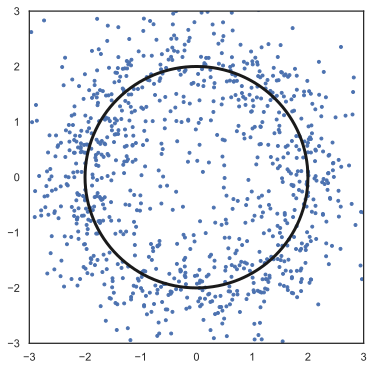

In [12]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
circle = plt.Circle((0, 0), 2.0, color="k", fill=False, lw=3)
ax.scatter(chm["x"], chm["y"], marker=".")
ax.add_artist(circle)

We can improve the quality of the approximation by providing a custom proposal.

In [13]:
@genjax.gen
def custom_q(target):
    chm = target.constraints
    z = chm["z"]
    θ = TFPUniform(0.0, 2 * π) @ "θ"
    x = Normal(jnp.sqrt(z) * jnp.cos(θ), 0.2) @ "x"
    y = Normal(jnp.sqrt(z) * jnp.sin(θ), 0.2) @ "y"

When run within the sampling importance resampling routine, the custom proposal is allowed to inspect the observed data (here, `chm`).

Note that `custom_q` samples auxiliary randomness for the `"θ"` address - to correctly define the importance weight density ratio, we need to marginalize out `"θ"`.

In [14]:
prox_custom_q = prox.chm_dist(custom_q, selection=genjax.select(["x", "y"]))

In [15]:
prox_is = prox.importance(50, prox_custom_q)
prox_is

Importance
├── num_particles
│   └── (const) 50
└── proposal
    └── ChoiceMapDistribution
        ├── p
        │   └── BuiltinGenerativeFunction
        │       └── source
        │           └── <function custom_q>
        ├── selection
        │   └── BuiltinSelection
        │       └── trie
        │           └── Trie
        │               ├── :x
        │               │   └── AllSelection
        │               └── :y
        │                   └── AllSelection
        └── custom_q
            └── (const) None

In [16]:
key, sub_keys = genjax.slash(key, 1000)
_, tr = jax.jit(jax.vmap(prox_is.simulate, in_axes=(0, None)))(sub_keys, (target,))
chm = tr.get_retval()
chm

BuiltinChoiceMap
└── trie
    └── Trie
        ├── :x
        │   └── ValueChoiceMap
        │       └── value
        │           └──  f32[1000]
        └── :y
            └── ValueChoiceMap
                └── value
                    └──  f32[1000]

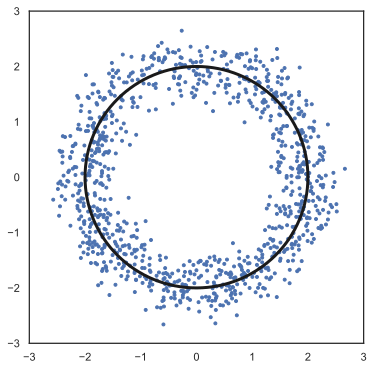

In [17]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
circle = plt.Circle((0, 0), 2.0, color="k", fill=False, lw=3)
ax.scatter(chm["x"], chm["y"], marker=".")
ax.add_artist(circle)